In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import optuna

/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8, 5))

sns.set_style("darkgrid")
sns.set_palette("deep")

title_style = dict(fontweight="heavy", fontfamily="arial")
scatter_style = dict(linewidth=0.2, edgecolor="k", alpha=0.85)

pd.options.display.max_columns = 25

In [3]:
df = pd.read_csv("/Users/kartikeyrana/Downloads/archive/train_dataset.csv")
print(f"Train shape: {df.shape}\n")
df.head()

Train shape: (38984, 23)



,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,97,239,153,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,88,211,128,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,80,193,120,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,249,210,366,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,100,179,200,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

In [5]:
def summary(df):
    summ = pd.DataFrame(index=df.columns)
    summ["dtype"] = df.dtypes
    summ["#missing_value"] = df.isna().sum().values
    summ["%missing_value"] = (df.isna().sum() / len(df)).values
    summ["#unique"] = df.nunique().values
    summ["min"] = df.min().values
    summ["max"] = df.max().values
    summ["mean"] = df.mean().values
    summ["std"] = df.std().values
    print("Number of duplicate rows:", df.duplicated().sum())
    print("\n")
    
    return summ

summary(df)

Number of duplicate rows: 5517




,dtype,#missing_value,%missing_value,#unique,min,max,mean,std
age,int64,0,0.0,14,20.0,85.0,44.127591,12.063564
height(cm),int64,0,0.0,13,130.0,190.0,164.689488,9.187507
weight(kg),int64,0,0.0,22,30.0,135.0,65.938718,12.896581
waist(cm),float64,0,0.0,545,51.0,129.0,82.062115,9.326798
eyesight(left),float64,0,0.0,19,0.1,9.9,1.014955,0.498527
eyesight(right),float64,0,0.0,17,0.1,9.9,1.008768,0.493813
hearing(left),int64,0,0.0,2,1.0,2.0,1.025369,0.157246
hearing(right),int64,0,0.0,2,1.0,2.0,1.026190,0.159703
systolic,int64,0,0.0,125,71.0,233.0,121.475631,13.643521
relaxation,int64,0,0.0,94,40.0,146.0,75.994408,9.658734


In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

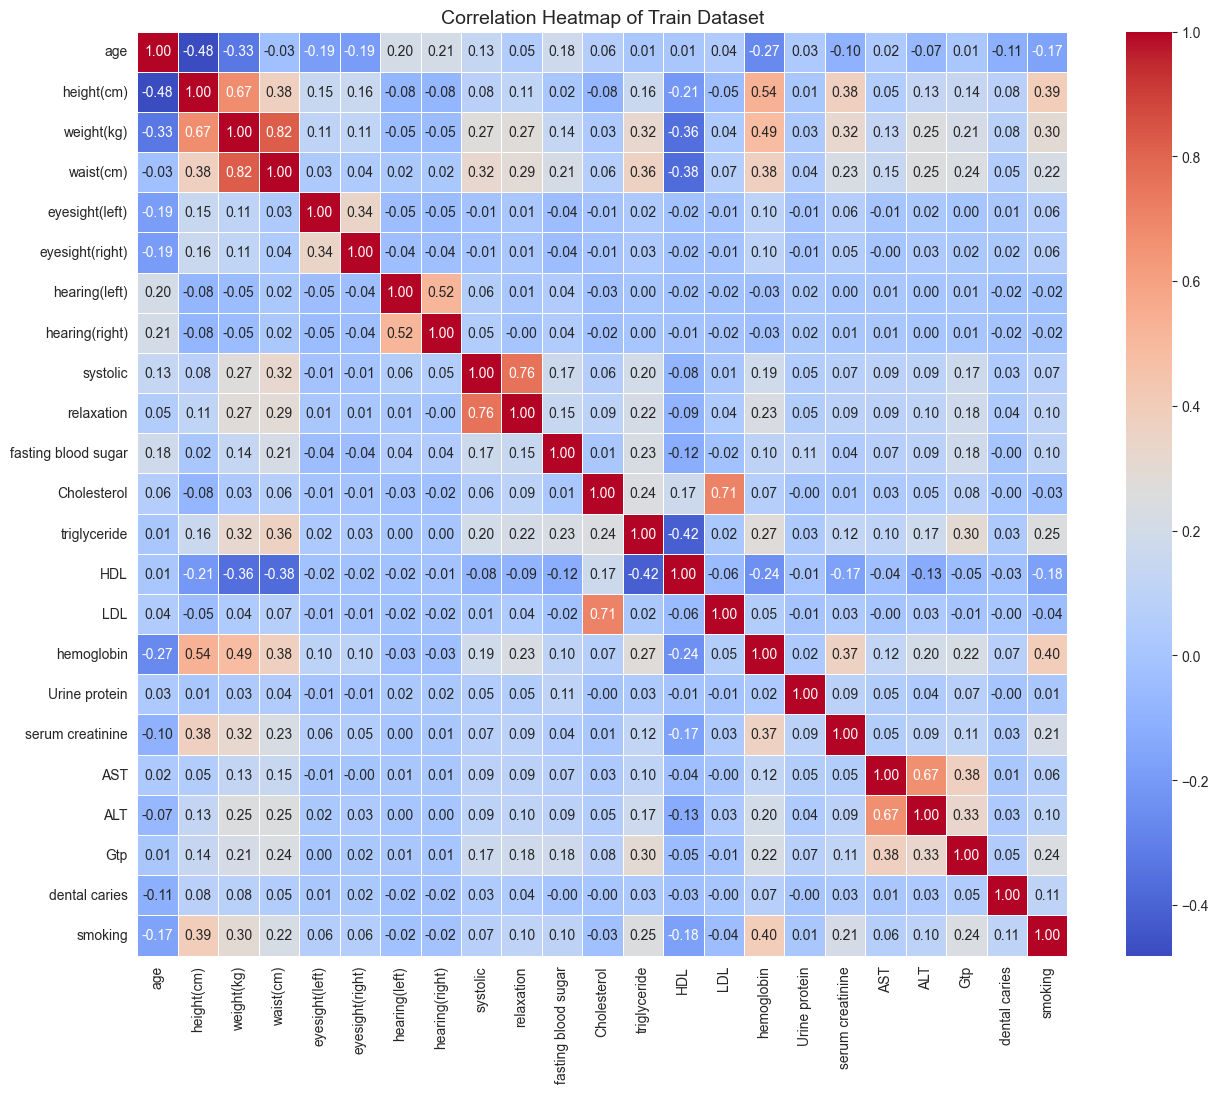

In [7]:
corr_matrix = df.corr()

plt.figure(figsize=(15, 12))  
sns.heatmap(corr_matrix, 
            annot=True,       
            fmt='.2f',        
            cmap='coolwarm',  
            linewidths=0.5)   
plt.title('Correlation Heatmap of Train Dataset')
plt.show()

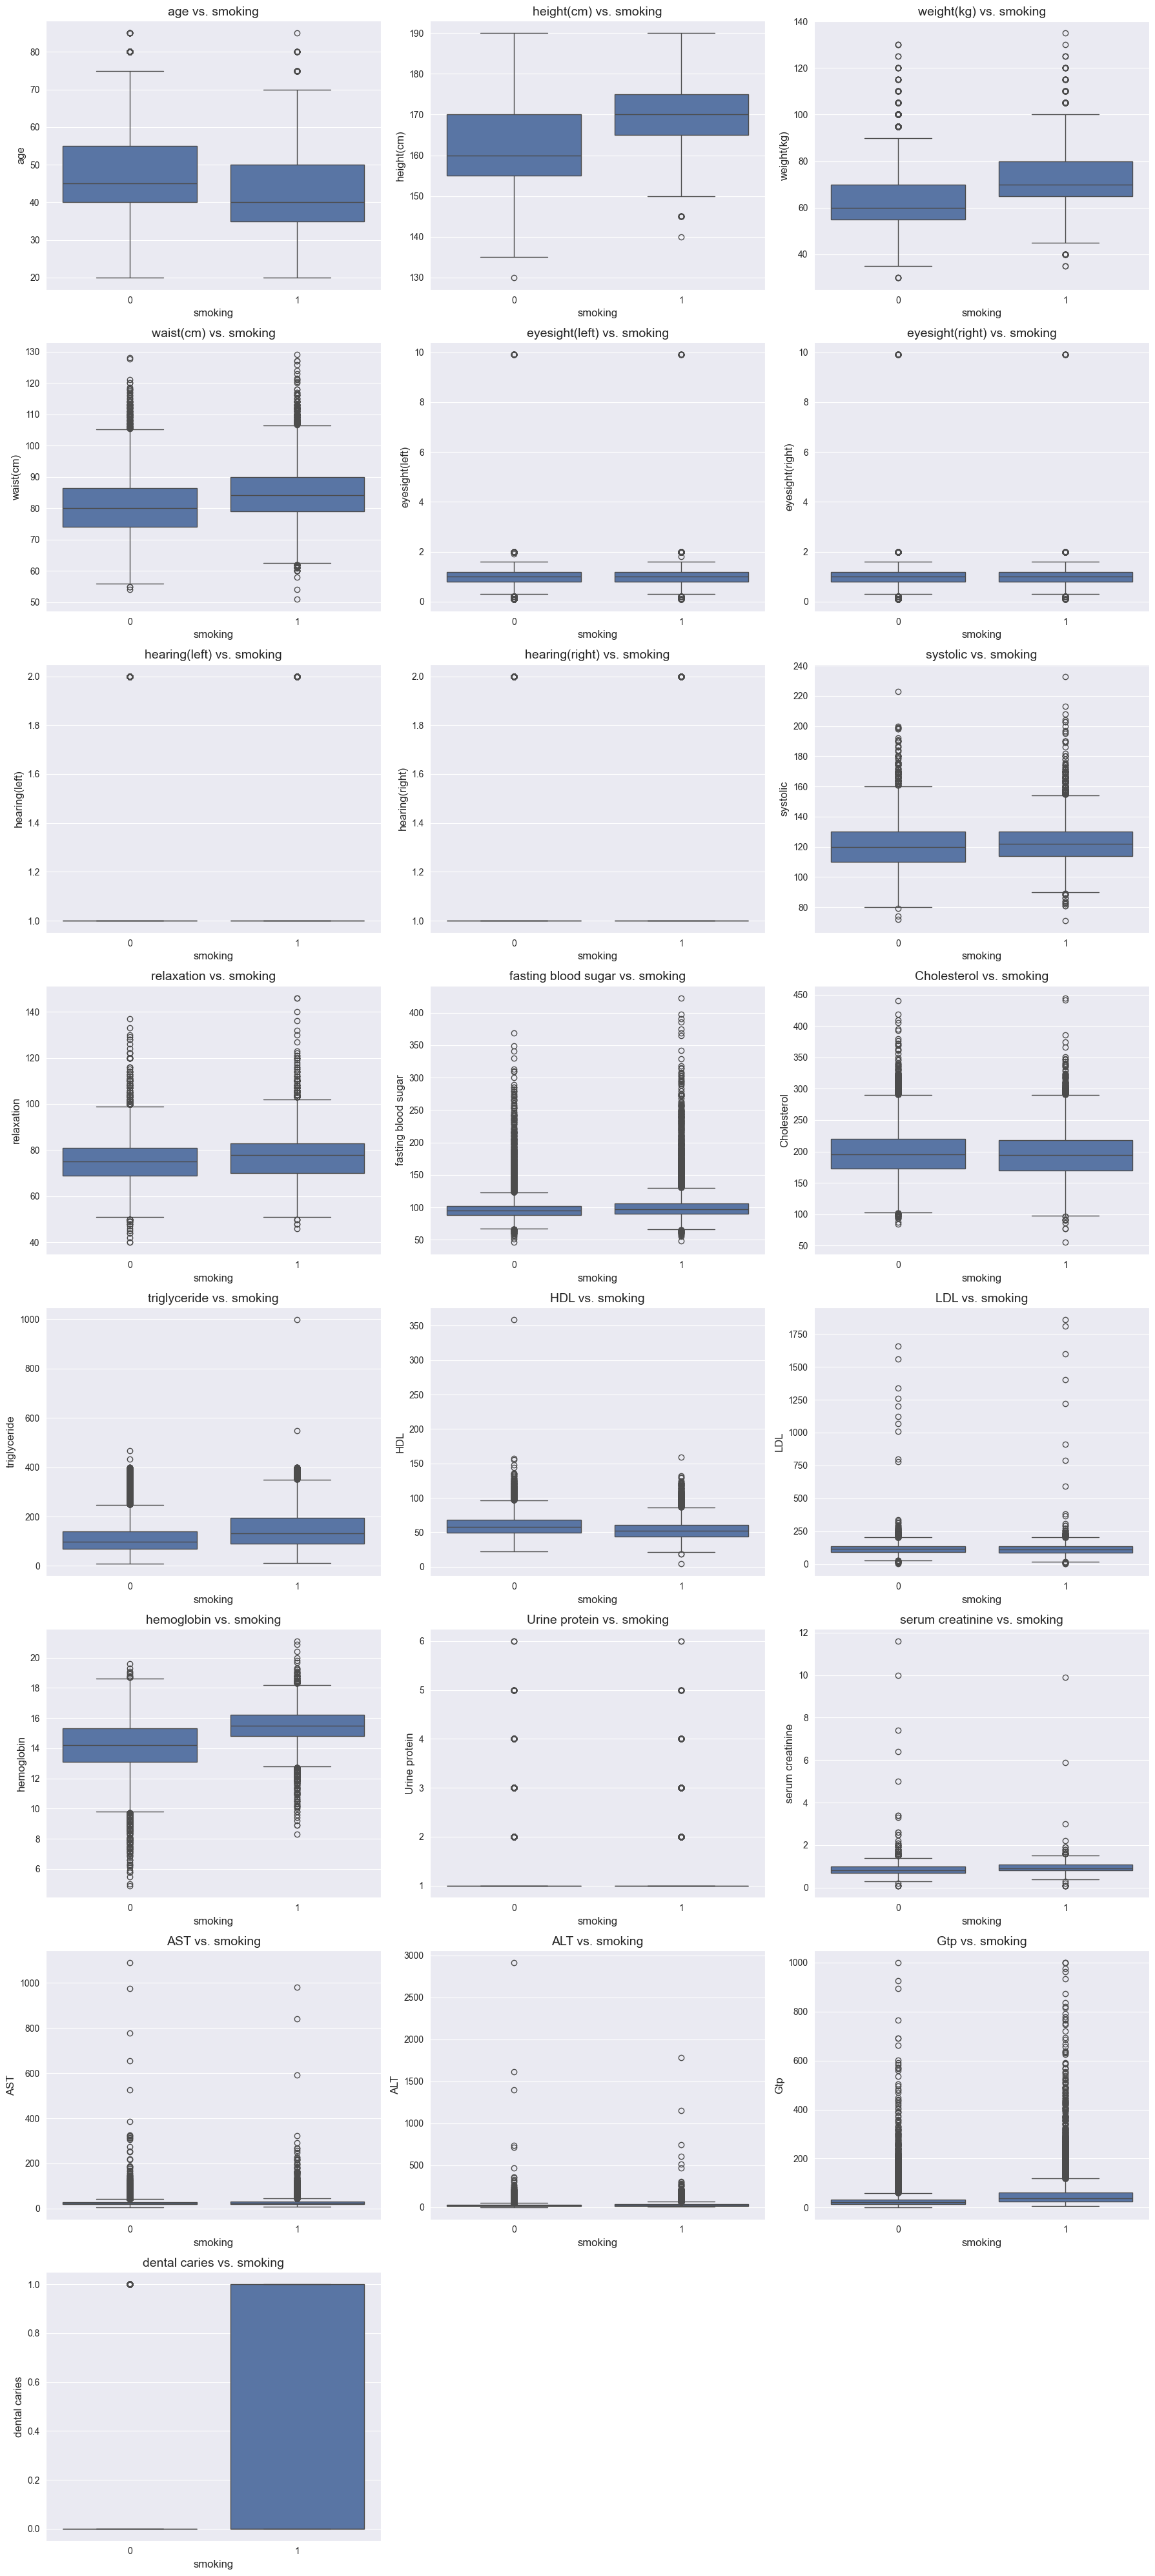

In [8]:
cat_cols = ["hearing_left", "hearing_right", "urine_protein", "dental_caries"]
num_cols = [col for col in df.columns if col not in cat_cols and col not in ["smoking"]]

num_plots = len(num_cols)
cols = 3
rows = math.ceil(num_plots / cols)  

fig = plt.figure(figsize=(18, 5 * rows)) 

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(data=df, y=col, x="smoking")
    plt.title(f"{col} vs. smoking")

plt.tight_layout() 
plt.show()

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Non-Linearity: Age Squared
df['age_squared'] = df['age'] ** 2

# Binary Flags for Categorical Health Metrics
# Hearing: 1=Normal, 2=Abnormal. We want 0=Normal, 1=Issue
df['hearing_issue'] = ((df['hearing(left)'] == 2) | (df['hearing(right)'] == 2)).astype(int)

# Calculate average hearing
df['avg_hearing'] = (df['hearing(left)'] + df['hearing(right)']) / 2

# Urine Protein: 1=Normal, >1=Abnormal
df['urine_issue'] = (df['Urine protein'] > 1).astype(int)

df['systolic_LDL_interaction'] = df['systolic'] * df['LDL']

df.drop(columns=['hearing(left)', 'hearing(right)', 'Urine protein'], inplace=True)

# Outlier Capping
clip_columns = ['AST', 'ALT', 'Gtp_log', 'triglyceride_log', 'serum creatinine']
for col in clip_columns:
    if col in df.columns:
        upper_limit = df[col].quantile(0.98)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])


In [10]:
# Blood Pressure Interactions
df['pulse_pressure'] = df['systolic'] - df['relaxation']

# Body Composition
df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)

# waist to height ratio
df['waist_to_height'] = df['waist(cm)'] / df['height(cm)']

# Calculate average eyesight
df['avg_eyesight'] = (df['eyesight(left)'] + df['eyesight(right)']) / 2

# Categorize blood pressure into ranges
# 0 for 'Normal', 1 for 'Prehypertension', 2 for 'Hypertension'
df['blood_pressure_category'] = pd.cut(df['systolic'], bins=[0, 120, 140, np.inf], labels=[0, 1, 2])    

# Cholesterol Ratios
df['cholesterol_ratio'] = df['LDL'] / (df['HDL'] + 1e-5)

# 4. Liver Enzyme Ratios
df['AST_ALT_ratio'] = df['AST'] / (df['ALT'] + 1e-5)

df['Gtp_log'] = np.log1p(df['Gtp'])
df['triglyceride_log'] = np.log1p(df['triglyceride'])

new_features = ['age_squared', 'pulse_pressure', 'BMI', 'waist_to_height', 'cholesterol_ratio', 'avg_eyesight', 
                'avg_hearing', 'AST_ALT_ratio', 'triglyceride_log','Gtp_log','hearing_issue', 'urine_issue', 
                'systolic_LDL_interaction', 'smoking']
print(df[new_features].corr()['smoking'].sort_values(ascending=False))



smoking                     1.000000
Gtp_log                     0.357137
triglyceride_log            0.254937
BMI                         0.104301
avg_eyesight                0.074430
cholesterol_ratio           0.069883
waist_to_height             0.028647
urine_issue                 0.010219
pulse_pressure             -0.005381
systolic_LDL_interaction   -0.020951
hearing_issue              -0.022444
avg_hearing                -0.023715
age_squared                -0.164446
AST_ALT_ratio              -0.183244
Name: smoking, dtype: float64


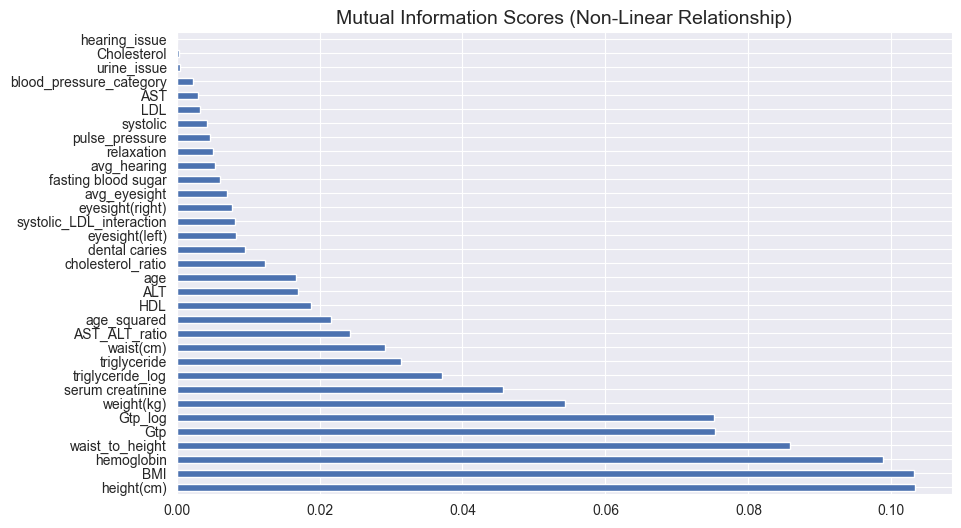

height(cm)                  0.103266
BMI                         0.103168
hemoglobin                  0.098842
waist_to_height             0.085800
Gtp                         0.075302
Gtp_log                     0.075217
weight(kg)                  0.054360
serum creatinine            0.045673
triglyceride_log            0.037109
triglyceride                0.031442
waist(cm)                   0.029137
AST_ALT_ratio               0.024262
age_squared                 0.021638
HDL                         0.018776
ALT                         0.016920
age                         0.016720
cholesterol_ratio           0.012381
dental caries               0.009535
eyesight(left)              0.008349
systolic_LDL_interaction    0.008171
eyesight(right)             0.007689
avg_eyesight                0.007054
fasting blood sugar         0.006057
avg_hearing                 0.005341
relaxation                  0.005136
pulse_pressure              0.004732
systolic                    0.004287
L

In [11]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import pandas as pd
import matplotlib.pyplot as plt

X_col = df.drop('smoking', axis=1)
y_col= df['smoking']
mi_scores = mutual_info_classif(X_col, y_col, random_state=42)

mi_series = pd.Series(mi_scores, index=X_col.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_series.plot(kind='barh')
plt.title("Mutual Information Scores (Non-Linear Relationship)")
plt.show()

print(mi_series)

In [12]:
cols_to_drop = [
    # 1. Zero Signal 
    'hearing_issue',          
    'avg_hearing',            
    'urine_issue',            
    'pulse_pressure',         
    'blood_pressure_category',
    
    # 2. Redundant / Better Representation Exists
    'AST',                    
    'Cholesterol',            
    'eyesight(left)',         
    'eyesight(right)',        
    
    # 3. Very Weak Predictors (MI < 0.01)
    'dental caries',          
    'relaxation',             
    'systolic',               
    'LDL',                    
    'fasting blood sugar'     
]

df_clean = df.drop(columns=cols_to_drop, errors='ignore')

print(f"Original shape: {df.shape}")
print(f"New shape:      {df_clean.shape}")
print("Remaining columns:", df_clean.columns.tolist())
df = df_clean

Original shape: (33467, 34)
New shape:      (33467, 20)
Remaining columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'triglyceride', 'HDL', 'hemoglobin', 'serum creatinine', 'ALT', 'Gtp', 'smoking', 'age_squared', 'systolic_LDL_interaction', 'BMI', 'waist_to_height', 'avg_eyesight', 'cholesterol_ratio', 'AST_ALT_ratio', 'Gtp_log', 'triglyceride_log']


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

X = df.drop('smoking', axis=1)
y = df['smoking']

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

robust_features = [
    'systolic_LDL_interaction', 'ALT', 'serum creatinine', 
    'HDL', 'AST_ALT_ratio', 'cholesterol_ratio'
]

standard_features = [col for col in numeric_cols if col not in robust_features]
print(standard_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_features),
        ('standard', StandardScaler(), standard_features)
    ],
    remainder='passthrough' 
)

X_train_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

all_cols = robust_features + standard_features
import pandas as pd
X = pd.DataFrame(X_train_processed, columns=all_cols)
X_test = pd.DataFrame(X_test_processed, columns=all_cols)

print("Scaling Complete. Robust Scaler applied to outlier-heavy columns.")

X_test.head()


['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'triglyceride', 'hemoglobin', 'Gtp', 'age_squared', 'BMI', 'waist_to_height', 'avg_eyesight', 'Gtp_log', 'triglyceride_log']
Scaling Complete. Robust Scaler applied to outlier-heavy columns.


,systolic_LDL_interaction,ALT,serum creatinine,HDL,AST_ALT_ratio,cholesterol_ratio,age,height(cm),weight(kg),waist(cm),triglyceride,hemoglobin,Gtp,age_squared,BMI,waist_to_height,avg_eyesight,Gtp_log,triglyceride_log
0,-0.065364,0.0625,0.5,1.210526,0.165264,-0.729023,-1.585750,1.669545,0.316031,0.099921,-1.027483,0.878142,-0.258666,-1.309015,-0.738261,-0.709500,0.224121,-0.107188,-1.345133
1,-0.262494,-0.3750,1.0,-0.526316,0.324485,0.002537,-0.759273,0.580408,-0.072271,0.099921,1.115504,-0.846855,-0.339214,-0.776129,-0.484347,-0.198366,-0.026391,-0.329415,1.178861
2,0.132803,0.5625,1.0,1.157895,0.637243,-0.595637,-0.759273,1.124977,-1.237176,-1.232913,-0.568271,-0.271856,14.703057,-0.776129,-2.250271,-1.796482,1.226170,4.672493,-0.452508
3,1.803562,1.9375,-0.5,1.736842,-0.428538,-0.204148,-0.346035,1.669545,0.704332,0.314894,0.600630,1.325364,1.352287,-0.443076,-0.296206,-0.500120,0.599889,1.838899,0.812256
4,-0.265260,0.3750,0.5,-0.789474,-0.801441,0.464350,0.067204,0.035839,0.704332,0.884573,0.767616,1.580919,-0.439898,-0.065615,0.964200,0.914148,0.098865,-0.666200,0.939195


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.1, random_state=42)

In [15]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (24095, 19)
y_train shape: (24095,)
X_val shape: (2678, 19)
y_val shape: (2678,)


## Neural Networks


In [16]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score

num_features = 19
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(num_features,)))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

model.compile(optimizer=tf.keras.optimizers.AdamW(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()

/opt/anaconda3/envs/tf_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,081 (617.50 KB)

 Trainable params: 158,081 (617.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

save_best_callback = ModelCheckpoint(
    'best_weights.keras',  
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [41]:
model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=[save_best_callback], validation_data=(X_val, y_val),verbose=2)

Epoch 1/50

Epoch 1: val_auc did not improve from 0.82159
189/189 - 0s - 2ms/step - auc: 0.9053 - loss: 0.3708 - val_auc: 0.7980 - val_loss: 0.5568
Epoch 2/50

Epoch 2: val_auc did not improve from 0.82159
189/189 - 0s - 3ms/step - auc: 0.9063 - loss: 0.3684 - val_auc: 0.8004 - val_loss: 0.5649
Epoch 3/50

Epoch 3: val_auc did not improve from 0.82159
189/189 - 0s - 2ms/step - auc: 0.9083 - loss: 0.3645 - val_auc: 0.8019 - val_loss: 0.5692
Epoch 4/50

Epoch 4: val_auc did not improve from 0.82159
189/189 - 0s - 2ms/step - auc: 0.9100 - loss: 0.3611 - val_auc: 0.8011 - val_loss: 0.5673
Epoch 5/50

Epoch 5: val_auc did not improve from 0.82159
189/189 - 0s - 2ms/step - auc: 0.9108 - loss: 0.3605 - val_auc: 0.7985 - val_loss: 0.5705
Epoch 6/50

Epoch 6: val_auc did not improve from 0.82159
189/189 - 0s - 2ms/step - auc: 0.9094 - loss: 0.3626 - val_auc: 0.7944 - val_loss: 0.5737
Epoch 7/50

Epoch 7: val_auc did not improve from 0.82159
189/189 - 0s - 2ms/step - auc: 0.9104 - loss: 0.3603 -

In [42]:
model = tf.keras.models.load_model('best_weights.keras')

In [43]:
y_pred = model.predict(X_test)

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred_labels = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Binary Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_labels))

Binary Accuracy: 74.69%
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      4179
           1       0.66      0.68      0.67      2515

    accuracy                           0.75      6694
   macro avg       0.73      0.73      0.73      6694
weighted avg       0.75      0.75      0.75      6694



210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step
Binary Accuracy: 74.69%
Test Loss: 0.4906
Test AUC:  0.8232

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      4179
           1       0.66      0.64      0.65      2515

    accuracy                           0.74      6694
   macro avg       0.72      0.72      0.72      6694
weighted avg       0.74      0.74      0.74      6694

ROC-AUC Score: 0.8232


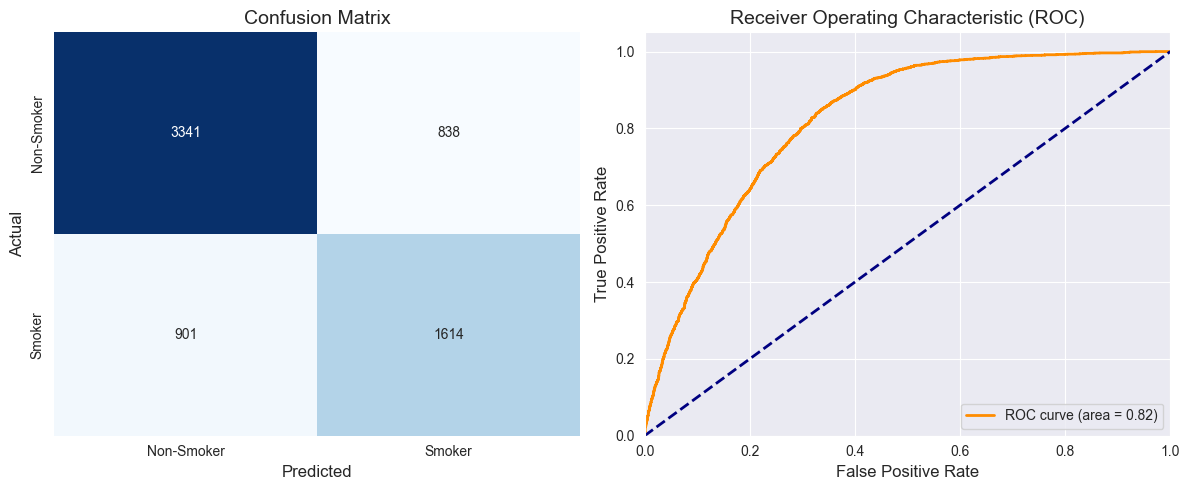

In [55]:
y_pred_probs = best_model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int) 

y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int) # Threshold at 0.5

print(f"Binary Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test AUC:  {results[1]:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_classes))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_probs):.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ['Non-Smoker', 'Smoker'])
plt.yticks([0.5, 1.5], ['Non-Smoker', 'Smoker'])

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {results[1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Logistic Regression

In [56]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore")

def objective(trial):
    
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    solver = "saga"
    
    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        l1_ratio=l1_ratio,
        class_weight=class_weight,
        max_iter=5000,  
        random_state=42,
        n_jobs=-1       
    )
    
    model.fit(X_train, y_train)
    
    y_val_probs = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_probs)
    
    return auc_score

study_lr = optuna.create_study(direction="maximize")
print("Starting Logistic Regression Tuning...")
study_lr.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nBest AUC: {study_lr.best_value:.4f}")
print("Best Params:", study_lr.best_params)

[I 2025-12-12 19:14:11,010] A new study created in memory with name: no-name-4517b4c6-f626-4917-9473-aa95b9aab4bc


Starting Logistic Regression Tuning...


Best trial: 0. Best value: 0.808537:   4%|▎      | 2/50 [00:04<01:32,  1.94s/it]

[I 2025-12-12 19:14:15,501] Trial 0 finished with value: 0.8085370543977309 and parameters: {'C': 2.118973164907291, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8085370543977309.
[I 2025-12-12 19:14:15,648] Trial 1 finished with value: 0.8071482656666907 and parameters: {'C': 0.007616914909685608, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8085370543977309.


Best trial: 0. Best value: 0.808537:   6%|▍      | 3/50 [00:04<00:51,  1.10s/it]

[I 2025-12-12 19:14:15,759] Trial 2 finished with value: 0.8062841037475059 and parameters: {'C': 0.005526518349798994, 'penalty': 'elasticnet', 'l1_ratio': 0.24333842968710517, 'class_weight': None}. Best is trial 0 with value: 0.8085370543977309.
[I 2025-12-12 19:14:15,830] Trial 3 finished with value: 0.8055209009398813 and parameters: {'C': 0.0025528978027207464, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8085370543977309.


Best trial: 0. Best value: 0.808537:  10%|▋      | 5/50 [00:05<00:26,  1.73it/s]

[I 2025-12-12 19:14:16,115] Trial 4 finished with value: 0.8064066969544001 and parameters: {'C': 0.03123910639195389, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.8085370543977309.
[I 2025-12-12 19:14:16,147] Trial 5 finished with value: 0.8015696738059181 and parameters: {'C': 0.0003583115936008875, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8085370543977309.


Best trial: 0. Best value: 0.808537:  14%|▉      | 7/50 [00:05<00:16,  2.58it/s]

[I 2025-12-12 19:14:16,415] Trial 6 finished with value: 0.8058796663541742 and parameters: {'C': 0.03165813529970188, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8085370543977309.


Best trial: 7. Best value: 0.808672:  16%|█      | 8/50 [00:11<01:13,  1.74s/it]

[I 2025-12-12 19:14:22,398] Trial 7 finished with value: 0.8086716665464773 and parameters: {'C': 0.21263428716817406, 'penalty': 'l1', 'class_weight': None}. Best is trial 7 with value: 0.8086716665464773.


Best trial: 8. Best value: 0.80919:  18%|█▍      | 9/50 [00:19<02:13,  3.27s/it]

[I 2025-12-12 19:14:30,071] Trial 8 finished with value: 0.8091896829403138 and parameters: {'C': 10.35811103812787, 'penalty': 'elasticnet', 'l1_ratio': 0.8618964664275341, 'class_weight': None}. Best is trial 8 with value: 0.8091896829403138.


Best trial: 8. Best value: 0.80919:  20%|█▍     | 10/50 [00:19<01:39,  2.48s/it]

[I 2025-12-12 19:14:30,401] Trial 9 finished with value: 0.8065815725583521 and parameters: {'C': 0.028540449757453148, 'penalty': 'elasticnet', 'l1_ratio': 0.5630736321095131, 'class_weight': 'balanced'}. Best is trial 8 with value: 0.8091896829403138.


Best trial: 8. Best value: 0.80919:  22%|█▌     | 11/50 [00:26<02:30,  3.87s/it]

[I 2025-12-12 19:14:37,900] Trial 10 finished with value: 0.8091854763106656 and parameters: {'C': 73.13266458248334, 'penalty': 'elasticnet', 'l1_ratio': 0.9495949329800989, 'class_weight': None}. Best is trial 8 with value: 0.8091896829403138.


Best trial: 8. Best value: 0.80919:  24%|█▋     | 12/50 [00:34<03:06,  4.90s/it]

[I 2025-12-12 19:14:45,404] Trial 11 finished with value: 0.8091854763106655 and parameters: {'C': 96.85381662708828, 'penalty': 'elasticnet', 'l1_ratio': 0.9898365676984144, 'class_weight': None}. Best is trial 8 with value: 0.8091896829403138.


Best trial: 8. Best value: 0.80919:  26%|█▊     | 13/50 [00:42<03:32,  5.74s/it]

[I 2025-12-12 19:14:53,220] Trial 12 finished with value: 0.8091860772577583 and parameters: {'C': 88.0163056512978, 'penalty': 'elasticnet', 'l1_ratio': 0.9989158207137248, 'class_weight': None}. Best is trial 8 with value: 0.8091896829403138.


Best trial: 13. Best value: 0.809213:  28%|█▍   | 14/50 [00:49<03:45,  6.27s/it]

[I 2025-12-12 19:15:00,762] Trial 13 finished with value: 0.809213119876926 and parameters: {'C': 4.053036823265815, 'penalty': 'elasticnet', 'l1_ratio': 0.6920813922747986, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  30%|█▌   | 15/50 [00:57<03:49,  6.57s/it]

[I 2025-12-12 19:15:08,045] Trial 14 finished with value: 0.8092065094589074 and parameters: {'C': 4.706548013114427, 'penalty': 'elasticnet', 'l1_ratio': 0.6656416723529306, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  32%|█▌   | 16/50 [01:03<03:42,  6.55s/it]

[I 2025-12-12 19:15:14,562] Trial 15 finished with value: 0.8090833153049206 and parameters: {'C': 0.9275208596041546, 'penalty': 'elasticnet', 'l1_ratio': 0.5584384012483119, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  34%|█▋   | 17/50 [01:11<03:47,  6.90s/it]

[I 2025-12-12 19:15:22,293] Trial 16 finished with value: 0.8091980961996106 and parameters: {'C': 5.637984598845654, 'penalty': 'elasticnet', 'l1_ratio': 0.6999992645822626, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  36%|█▊   | 18/50 [01:15<03:15,  6.11s/it]

[I 2025-12-12 19:15:26,525] Trial 17 finished with value: 0.8089150501189875 and parameters: {'C': 0.3583583715451827, 'penalty': 'elasticnet', 'l1_ratio': 0.2896325711639977, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  38%|█▉   | 19/50 [01:22<03:21,  6.50s/it]

[I 2025-12-12 19:15:33,950] Trial 18 finished with value: 0.8085412610273791 and parameters: {'C': 13.955038184650917, 'penalty': 'elasticnet', 'l1_ratio': 0.7588462908247464, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  40%|██   | 20/50 [01:30<03:24,  6.81s/it]

[I 2025-12-12 19:15:41,494] Trial 19 finished with value: 0.8091806687339247 and parameters: {'C': 1.6192480892534324, 'penalty': 'l1', 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  42%|██   | 21/50 [01:38<03:24,  7.05s/it]

[I 2025-12-12 19:15:49,091] Trial 20 finished with value: 0.8091980961996106 and parameters: {'C': 22.941030140119654, 'penalty': 'elasticnet', 'l1_ratio': 0.4620248083700647, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  44%|██▏  | 22/50 [01:45<03:23,  7.25s/it]

[I 2025-12-12 19:15:56,817] Trial 21 finished with value: 0.8092004999879809 and parameters: {'C': 4.7091335701253865, 'penalty': 'elasticnet', 'l1_ratio': 0.7195170097974879, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  46%|██▎  | 23/50 [01:53<03:18,  7.33s/it]

[I 2025-12-12 19:16:04,348] Trial 22 finished with value: 0.809210115141463 and parameters: {'C': 4.226254527169122, 'penalty': 'elasticnet', 'l1_ratio': 0.6946034988940738, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  48%|██▍  | 24/50 [01:58<02:54,  6.72s/it]

[I 2025-12-12 19:16:09,632] Trial 23 finished with value: 0.8089625249393044 and parameters: {'C': 0.47187699226659546, 'penalty': 'elasticnet', 'l1_ratio': 0.4445226062940448, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  50%|██▌  | 25/50 [02:01<02:17,  5.52s/it]

[I 2025-12-12 19:16:12,348] Trial 24 finished with value: 0.8083766015240018 and parameters: {'C': 0.1293796284125105, 'penalty': 'elasticnet', 'l1_ratio': 0.6408174972635539, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  52%|██▌  | 26/50 [02:08<02:26,  6.10s/it]

[I 2025-12-12 19:16:19,788] Trial 25 finished with value: 0.8091968943054253 and parameters: {'C': 2.7958605091718254, 'penalty': 'elasticnet', 'l1_ratio': 0.8431727894721287, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  54%|██▋  | 27/50 [02:16<02:29,  6.50s/it]

[I 2025-12-12 19:16:27,227] Trial 26 finished with value: 0.8085448667099349 and parameters: {'C': 33.09554667450096, 'penalty': 'elasticnet', 'l1_ratio': 0.3674877857557702, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.809213119876926.


Best trial: 13. Best value: 0.809213:  56%|██▊  | 28/50 [02:21<02:12,  6.04s/it]

[I 2025-12-12 19:16:32,185] Trial 27 finished with value: 0.8090136054421768 and parameters: {'C': 0.6311418544113114, 'penalty': 'elasticnet', 'l1_ratio': 0.09279114870310629, 'class_weight': None}. Best is trial 13 with value: 0.809213119876926.


Best trial: 28. Best value: 0.809218:  58%|██▉  | 29/50 [02:26<02:01,  5.78s/it]

[I 2025-12-12 19:16:37,360] Trial 28 finished with value: 0.809217927453667 and parameters: {'C': 7.348038789389482, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  60%|███  | 30/50 [02:30<01:45,  5.29s/it]

[I 2025-12-12 19:16:41,523] Trial 29 finished with value: 0.8084937862070625 and parameters: {'C': 1.4166444961222038, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  62%|███  | 31/50 [02:35<01:40,  5.31s/it]

[I 2025-12-12 19:16:46,872] Trial 30 finished with value: 0.8091908848344991 and parameters: {'C': 26.084018408737453, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  64%|███▏ | 32/50 [02:40<01:34,  5.24s/it]

[I 2025-12-12 19:16:51,932] Trial 31 finished with value: 0.8092089132472776 and parameters: {'C': 5.227783848390631, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  66%|███▎ | 33/50 [02:46<01:29,  5.25s/it]

[I 2025-12-12 19:16:57,222] Trial 32 finished with value: 0.8092017018821664 and parameters: {'C': 8.983561485188538, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  68%|███▍ | 34/50 [02:51<01:22,  5.15s/it]

[I 2025-12-12 19:17:02,137] Trial 33 finished with value: 0.8091752602100911 and parameters: {'C': 2.6701597947556075, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  70%|███▌ | 35/50 [02:56<01:16,  5.10s/it]

[I 2025-12-12 19:17:07,119] Trial 34 finished with value: 0.8091662460037018 and parameters: {'C': 2.5199652981478056, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  72%|███▌ | 36/50 [03:01<01:12,  5.20s/it]

[I 2025-12-12 19:17:12,556] Trial 35 finished with value: 0.8091824715752026 and parameters: {'C': 16.585804071501485, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  74%|███▋ | 37/50 [03:07<01:08,  5.30s/it]

[I 2025-12-12 19:17:18,099] Trial 36 finished with value: 0.8091986971467033 and parameters: {'C': 39.981188604339984, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.
[I 2025-12-12 19:17:18,138] Trial 37 finished with value: 0.7961341073531886 and parameters: {'C': 0.0001285980228536558, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  78%|███▉ | 39/50 [03:07<00:33,  3.02s/it]

[I 2025-12-12 19:17:18,814] Trial 38 finished with value: 0.8081927117136607 and parameters: {'C': 0.05216428811571103, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.
[I 2025-12-12 19:17:18,896] Trial 39 finished with value: 0.8059535828465662 and parameters: {'C': 0.00647691844372645, 'penalty': 'l1', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  82%|████ | 41/50 [03:09<00:20,  2.26s/it]

[I 2025-12-12 19:17:21,011] Trial 40 finished with value: 0.8088219033196318 and parameters: {'C': 0.24903673636634727, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  84%|████▏| 42/50 [03:15<00:23,  2.90s/it]

[I 2025-12-12 19:17:26,161] Trial 41 finished with value: 0.8092047066176294 and parameters: {'C': 5.280761005512287, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  86%|████▎| 43/50 [03:22<00:28,  4.02s/it]

[I 2025-12-12 19:17:33,750] Trial 42 finished with value: 0.8091854763106656 and parameters: {'C': 7.181418810308116, 'penalty': 'l1', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  88%|████▍| 44/50 [03:29<00:28,  4.77s/it]

[I 2025-12-12 19:17:40,686] Trial 43 finished with value: 0.8091307901252375 and parameters: {'C': 1.369652788231256, 'penalty': 'elasticnet', 'l1_ratio': 0.5988924315702717, 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.
[I 2025-12-12 19:17:40,738] Trial 44 finished with value: 0.8059121174971756 and parameters: {'C': 0.0017559690931508924, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  92%|████▌| 46/50 [03:37<00:17,  4.38s/it]

[I 2025-12-12 19:17:48,388] Trial 45 finished with value: 0.8091854763106656 and parameters: {'C': 49.75612324084692, 'penalty': 'elasticnet', 'l1_ratio': 0.8008139097113208, 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  94%|████▋| 47/50 [03:44<00:15,  5.10s/it]

[I 2025-12-12 19:17:55,858] Trial 46 finished with value: 0.8085286411384341 and parameters: {'C': 3.6885615138713765, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  96%|████▊| 48/50 [03:51<00:11,  5.53s/it]

[I 2025-12-12 19:18:02,683] Trial 47 finished with value: 0.8090917285642172 and parameters: {'C': 0.7947397490898446, 'penalty': 'elasticnet', 'l1_ratio': 0.6661078023525119, 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218:  98%|████▉| 49/50 [03:59<00:06,  6.11s/it]

[I 2025-12-12 19:18:10,428] Trial 48 finished with value: 0.8092035047234443 and parameters: {'C': 13.704290682627416, 'penalty': 'elasticnet', 'l1_ratio': 0.8950417371255472, 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.


Best trial: 28. Best value: 0.809218: 100%|█████| 50/50 [04:04<00:00,  4.89s/it]

[I 2025-12-12 19:18:15,729] Trial 49 finished with value: 0.8091902838874065 and parameters: {'C': 10.58641328688208, 'penalty': 'l2', 'class_weight': None}. Best is trial 28 with value: 0.809217927453667.

Best AUC: 0.8092
Best Params: {'C': 7.348038789389482, 'penalty': 'l2', 'class_weight': None}


Final Test AUC: 0.8134

Classification Report:
Accuracy: 72.59%
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      4179
           1       0.65      0.58      0.62      2515

    accuracy                           0.73      6694
   macro avg       0.71      0.70      0.70      6694
weighted avg       0.72      0.73      0.72      6694



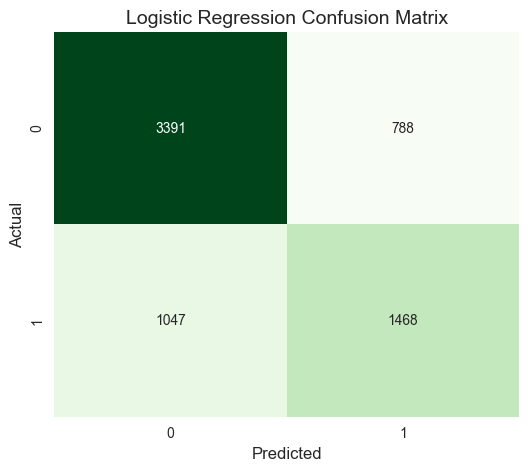

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

best_params = study_lr.best_params

l1_ratio = best_params.get("l1_ratio", None) 

final_lr = LogisticRegression(
    C=best_params["C"],
    penalty=best_params["penalty"],
    l1_ratio=l1_ratio,
    class_weight=best_params["class_weight"],
    solver="saga",
    max_iter=5000,
    random_state=42,
    n_jobs=-1
)

final_lr.fit(X_train, y_train)

y_test_probs = final_lr.predict_proba(X_test)[:, 1]
y_test_pred = final_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_test_pred)
print(f"Final Test AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
print("\nClassification Report:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print(classification_report(y_test, y_test_pred))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## SVM

In [16]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score

def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    degree = 3
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 4)
    
    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        probability=True, 
        random_state=42,
        cache_size=1000   
    )
    model.fit(X_train, y_train)
    preds_proba = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, preds_proba)
    
    return score

print("Starting SVM Tuning (This may take a while)...")
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective, n_trials=20, show_progress_bar=True, n_jobs = -1) 

print(f"\nBest AUC: {study_svm.best_value:.4f}")
print("Best Params:", study_svm.best_params)

[I 2025-12-12 19:40:47,502] A new study created in memory with name: no-name-ea1a5dc7-096c-4c5e-9203-ee42b4237299


Starting SVM Tuning (This may take a while)...


Best trial: 1. Best value: 0.807076:   5%|▎      | 1/20 [01:07<21:13, 67.03s/it]

[I 2025-12-12 19:41:54,536] Trial 1 finished with value: 0.8070761520155766 and parameters: {'C': 0.0011929243518726995, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 1 with value: 0.8070761520155766.


Best trial: 6. Best value: 0.807343:  10%|▋      | 2/20 [01:11<09:02, 30.16s/it]

[I 2025-12-12 19:41:58,890] Trial 6 finished with value: 0.807343272998245 and parameters: {'C': 0.0026781411507641757, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 6 with value: 0.807343272998245.


Best trial: 4. Best value: 0.808603:  15%|█      | 3/20 [01:23<06:09, 21.73s/it]

[I 2025-12-12 19:42:10,580] Trial 4 finished with value: 0.8086031585779188 and parameters: {'C': 0.0791510647306438, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 4 with value: 0.8086031585779188.


Best trial: 7. Best value: 0.808719:  20%|█▍     | 4/20 [01:35<04:48, 18.06s/it]

[I 2025-12-12 19:42:23,004] Trial 7 finished with value: 0.8087185404197014 and parameters: {'C': 0.13418732021968144, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 7 with value: 0.8087185404197014.


Best trial: 5. Best value: 0.810356:  25%|█▊     | 5/20 [02:02<05:20, 21.34s/it]

[I 2025-12-12 19:42:50,163] Trial 5 finished with value: 0.8103561212470853 and parameters: {'C': 0.6027523116464, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  30%|██     | 6/20 [02:24<05:00, 21.45s/it]

[I 2025-12-12 19:43:11,811] Trial 9 finished with value: 0.8066720150957909 and parameters: {'C': 0.010242382906072475, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  35%|██▍    | 7/20 [02:28<03:24, 15.75s/it]

[I 2025-12-12 19:43:15,822] Trial 3 finished with value: 0.804575310689647 and parameters: {'C': 0.007297960500562011, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  40%|██▊    | 8/20 [02:42<03:03, 15.29s/it]

[I 2025-12-12 19:43:30,129] Trial 0 finished with value: 0.8089733419869716 and parameters: {'C': 1.2852610566318572, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  45%|███▏   | 9/20 [02:59<02:53, 15.78s/it]

[I 2025-12-12 19:43:46,995] Trial 12 finished with value: 0.8086794788586814 and parameters: {'C': 0.114788216019719, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  50%|███   | 10/20 [03:11<02:25, 14.54s/it]

[I 2025-12-12 19:43:58,775] Trial 11 finished with value: 0.683369991105983 and parameters: {'C': 0.0012852768296327199, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  55%|███▎  | 11/20 [03:18<01:49, 12.21s/it]

[I 2025-12-12 19:44:05,732] Trial 14 finished with value: 0.8070418980312972 and parameters: {'C': 0.0010959499180544616, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 5. Best value: 0.810356:  60%|███▌  | 12/20 [03:26<01:27, 10.88s/it]

[I 2025-12-12 19:44:13,547] Trial 10 finished with value: 0.8005062979255306 and parameters: {'C': 3.5707694098129448, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 5 with value: 0.8103561212470853.


Best trial: 13. Best value: 0.813074:  65%|███▎ | 13/20 [03:35<01:13, 10.51s/it]

[I 2025-12-12 19:44:23,216] Trial 13 finished with value: 0.8130736039999039 and parameters: {'C': 0.11453304099368347, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074:  70%|███▌ | 14/20 [03:48<01:07, 11.25s/it]

[I 2025-12-12 19:44:36,180] Trial 16 finished with value: 0.8012109083916251 and parameters: {'C': 0.03640466682722728, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074:  75%|███▊ | 15/20 [04:03<01:00, 12.19s/it]

[I 2025-12-12 19:44:50,555] Trial 15 finished with value: 0.8123644864306148 and parameters: {'C': 0.04447594455163172, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074:  80%|████ | 16/20 [04:08<00:41, 10.27s/it]

[I 2025-12-12 19:44:56,357] Trial 17 finished with value: 0.7172489843994135 and parameters: {'C': 0.02425585968916867, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074:  85%|████▎| 17/20 [04:17<00:29,  9.82s/it]

[I 2025-12-12 19:45:05,150] Trial 18 finished with value: 0.8071410543015791 and parameters: {'C': 1.1692414124813775, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074:  90%|████▌| 18/20 [05:01<00:40, 20.14s/it]

[I 2025-12-12 19:45:49,312] Trial 2 finished with value: 0.7547769284392202 and parameters: {'C': 14.225306411110864, 'kernel': 'poly', 'gamma': 'auto', 'degree': 4}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074:  95%|████▊| 19/20 [05:20<00:19, 19.76s/it]

[I 2025-12-12 19:46:08,196] Trial 19 finished with value: 0.7753599673084781 and parameters: {'C': 69.9448361837568, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 13 with value: 0.8130736039999039.


Best trial: 13. Best value: 0.813074: 100%|█████| 20/20 [05:36<00:00, 16.83s/it]

[I 2025-12-12 19:46:24,199] Trial 8 finished with value: 0.8090646859450492 and parameters: {'C': 15.575981984109049, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 13 with value: 0.8130736039999039.

Best AUC: 0.8131
Best Params: {'C': 0.11453304099368347, 'kernel': 'rbf', 'gamma': 'auto'}


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

best_params = study_svm.best_params

final_svm = SVC(
    C=best_params["C"],
    kernel=best_params["kernel"],
    gamma=best_params["gamma"],
    degree=best_params.get("degree", 3), 
    probability=True,  
    random_state=42
)

print("Training Final SVM Model...")
final_svm.fit(X_train, y_train)

y_pred = final_svm.predict(X_test)
y_pred_proba = final_svm.predict_proba(X_test)[:, 1]

final_accuracy = accuracy_score(y_test, y_pred)
print(f"\n>>> Final Test Accuracy: {final_accuracy * 100:.2f}% <<<")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Training Final SVM Model...

>>> Final Test Accuracy: 73.56% <<<

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      4179
           1       0.66      0.60      0.63      2515

    accuracy                           0.74      6694
   macro avg       0.72      0.71      0.71      6694
weighted avg       0.73      0.74      0.73      6694

ROC-AUC Score: 0.8196
